# One Hidden Layer NN
---
We will build a shallow dense neural network with one hidden layer, and and the following structure is used for illustration purpose.

<img src='images/1-hidden-nn.png'>

Where in the graph above, we have a input vector $x = (x_1, x_2)$, containing 2 features and 4 hidden units $a1, a2, a3$ and $a4$, and output one value $y_1 \in [0, 1]$ (consider this a binary classification task with a prediction of probability)

In each hidden unit, take $a_1$ as example, a linear operation followed by an activation function is conducted. So given input $x = (x_1, x_2)$, inside node $a_1$, we have:

$$z_1 = w_{11}x_1 + w_{12}x_2$$
$$a_1 = activation(z_1)$$

Here $w_{11}$ denotes weight 1 of node 1, $w_{12}$ denotes weight 2 of node 1. Same for node $a_2$, it would have:

$$z_2 = w_{21}x_1 + w_{22}x_2$$
$$a_2 = activation(z_2)$$

And $a_3$ and $a_4$ so on ...

# Vectorization of One Input
---
Now let's put the weights into matrix and input into a vector to simplify the expression.

$$ z^{[1]} = W^{[1]}x + b^{[1]} \tag1 $$

$$ a^{[1]} = \tanh{Z^{[1]}} \tag2 $$

$$ z^{[2]} = W^{[2]}a^{[1]} + b^{[2]} \tag3 $$

$$ \hat{y} = a^{[2]} = \sigma({Z^{[2]}}) \tag4 $$

$$ L(y, \hat{y}) = -[y\log{\hat{y}} + (1 - y)\log{(1 - \hat{y})}] $$

Here we've assumed that the second activation function to be $\tanh$ and the output activation function to be $sigmoid$ (note that superscript $[i]$ denotes $ith$ layer). 

For the dimention of each matrix, we have:

- $ W^{[1]}$ in the case above would have dimension $4 \times 2$, with each $ith$ row is the weight of node $i$
- $b^{[1]}$ has dimension $4 \times 1$
- $z^{[1]}$ and $a^{[1]}$ both have dimention $4 \times 1$
- $W^{[2]}$ has dimension $1 \times 4$
- consequently, $z^{[2]}$ and $a^{[2]}$ would have dimensition $1 \times 1$, which is a single value

The loss function $L$ for a single value would be the same as logistic regression's.

Function $\tanh$ and $sigmoid$ looks as below.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def tanh(x):
    return np.tanh(x)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

Text(0.5, 1.0, 'tanh')

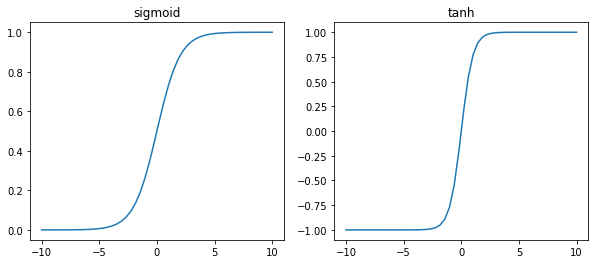

In [7]:
plt.figure(figsize=[10, 4])
x = np.linspace(-10, 10)

plt.subplot(1, 2, 1)
plt.plot(x, sigmoid(x))
plt.title('sigmoid')

plt.subplot(1, 2, 2)
plt.plot(x, tanh(x))
plt.title('tanh')

Notice that the only difference of these functions are the scale of y

# Formula of Batch Training
---
The above shows the formula of an single input vector, however in actual training processes, a batch is trained instead of 1 at a time. The change applied in the formula is trivial, we just need to replace the single vector $x$ with a matrix $X$ with size $n \times m$, where $n$ is number of features and $m$ is the the batch size -- samples are stacked column wise, and the following result matrix are applied likewise.

$$ Z^{[1]} = W^{[1]}X + b^{[1]} \tag5 $$

$$ A^{[1]} = \tanh{Z^{[1]}} \tag6 $$

$$ Z^{[2]} = W^{[2]}A^{[1]} + b^{[2]} \tag7 $$

$$ \hat{Y} = A^{[2]} = \sigma({Z^{[2]}}) \tag8 $$

$$ J(W^{[1]}, b^{[1]}, W^{[2]}, b^{[2]}) = \frac{1}{m} \sum_{i}^{m}L(y^{(i)}, \hat{y}^{(i)}) \tag9 $$

For the dimention of each matrix taken in this example, we have:

- $X$ has dimension $2 \times m$, as here there are 2 features and $m$ is the batch size
- $W^{[1]}$ in the case above would have dimension $4 \times 2$, with each $ith$ row is the weight of node $i$
- $b^{[1]}$ has dimension $4 \times 1$
- $Z^{[1]}$ and $A^{[1]}$ both have dimention $4 \times m$
- $W^{[2]}$ has dimension $1 \times 4$
- consequently, $Z^{[2]}$ and $A^{[2]}$ would have dimensition $1 \times m$

Same as logistic regression, for batch training, the average loss for all training samples.

This is all for the forward propagation. To activate our neurons to learn, we need to get derivative of weight parameters and update them use gradient descent.

But now it is enough for us to implement the forward propagation first.

# Generate Sample Dataset
---
Here we generate a simple binary classification task with 5000 data points and 20 features for later model validation.

In [8]:
from sklearn import datasets


X, y = datasets.make_classification(n_samples=5000, random_state=123)

X_train, X_test = X[:4000], X[4000:]
y_train, y_test = y[:4000], y[4000:]

print('train shape', X_train.shape)
print('test shape', X_test.shape)

train shape (4000, 20)
test shape (1000, 20)


# Weights Initialization
---
Our neural network has 1 hidden layer and 2 layers in total(hidden layer + output layer), so there are 4 weight matrices to initialize ($W^{[1]}, b^{[1]}$ and $W^{[2]}, b^{[2]}$).

In [16]:
def init_weights(n_input, n_hidden, n_output):
    params = {}
    params['W1'] = np.random.randn(n_hidden, n_input) * 0.01
    params['b1'] = np.zeros((n_hidden, 1))
    params['W2'] = np.random.randn(n_output, n_hidden) * 0.01
    params['b2'] = np.zeros((n_output, 1))
    
    return params

In [17]:
params = init_weights(20, 10, 1)

print('W1 shape', params['W1'].shape)
print('b1 shape', params['b1'].shape)
print('W2 shape', params['W2'].shape)
print('b2 shape', params['b2'].shape)

W1 shape (10, 20)
b1 shape (10, 1)
W2 shape (1, 10)
b2 shape (1, 1)


# Forward Propagation
---
Let's implement the forward process following equations $(5) \sim (8)$.

In [27]:
def forward(X, params):
    """
    X: need to have shape (n_features x m_samples)
    """
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    A0 = X
    
    cache = {}
    Z1 = np.dot(W1, A0) + b1
    A1 = tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    cache['Z1'] = Z1
    cache['A1'] = A1
    cache['Z2'] = Z2
    cache['A2'] = A2
    return  cache

In [30]:
# get 100 samples
inp = X[:100].T

cache = forward(inp, params)

print('Z1 shape', cache['Z1'].shape)
print('A1 shape', cache['A1'].shape)
print('Z2 shape', cache['Z2'].shape)
print('A2 shape', cache['A2'].shape)

Z1 shape (10, 100)
A1 shape (10, 100)
Z2 shape (1, 100)
A2 shape (1, 100)


# Loss Function
---
Following equation $(9)$, let's calculate the loss of each batch.

In [31]:
a = np.random.randn(1, 5)
a

array([[-0.54450284,  1.05200455,  0.52662129,  2.1650654 , -0.51482226]])

In [32]:
a*a

array([[0.29648334, 1.10671357, 0.27732998, 4.68750821, 0.26504196]])

In [60]:
def loss(Y, Y_hat):
    """
    Y: vector of true value
    Y_hat: vector of predicted value
    """
    assert Y.shape == Y_hat.shape
    m = len(Y)
    s = Y * np.log(Y_hat) + (1 - Y) * np.log(1 - Y_hat)
    print(s)
    loss = -np.sum(s) / m
    return loss, s

In [61]:
Y = np.array([np.random.choice([0, 1]) for i in range(10)]).reshape(1, -1)
Y_hat = np.random.uniform(0, 1, 10).reshape(1, -1)

l, s = loss(Y, Y_hat)
print(f'loss {l}')

[[-0.15024009 -1.07448806 -4.23457266 -0.01917835 -0.11287872 -0.08862429
  -0.70900882 -0.71550035 -1.68340973 -0.76540768]]
loss 9.553308745225344


In [63]:
len(Y)

1

In [57]:
np.sum(s)

-5.9133604633525305

In [46]:
Y

array([[0, 0, 1, 0, 0, 1, 0, 0, 1, 1]])

In [47]:
Y_hat

array([[0.54935165, 0.69721024, 0.37640275, 0.38963589, 0.55689617,
        0.47491666, 0.25879804, 0.22274564, 0.63155235, 0.74739847]])

In [48]:
np.log(1-0.54935165)

-0.7970679553644306

In [59]:
-np.sum(s)/10

0.591336046335253